In [1]:
#imports

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import pathlib
layers = tf.keras.layers
from IPython.display import clear_output

In [2]:
BATCH_SIZE = 100
epochs = 1000 #max epoch number
train_dir = str("D:/img_align_celeba/*")
images_per_epoch = 56000

In [3]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder,self).__init__()
        self.model = None
        
  
        self.model = tf.keras.models.Sequential([
            layers.InputLayer(input_shape=(208, 176, 3)),
            layers.Conv2D(256, (6, 6), activation='relu', padding="SAME"),
            layers.GaussianDropout(0.3),
            layers.Conv2D(256, (6, 6), activation='relu', padding="SAME"),
            layers.GaussianDropout(0.3),
                        layers.MaxPool2D(),

            layers.Conv2D(128, (5, 5), activation='relu', padding="SAME"),
            layers.GaussianDropout(0.3),
            layers.Conv2D(128, (5, 5), activation='relu', padding="SAME"),
            layers.GaussianDropout(0.3),
                        layers.MaxPool2D(),

            layers.Conv2D(128, (4, 4), activation='relu',padding="SAME"),
            layers.GaussianDropout(0.3),
            layers.Conv2D(128, (4, 4), activation='relu',padding="SAME"),
            layers.GaussianDropout(0.3),
                        layers.MaxPool2D(),

            layers.Conv2D(128, (3, 3), activation='relu',padding="SAME"),
            layers.GaussianDropout(0.3),
            layers.Conv2D(128, (3, 3), activation='relu',padding="SAME"),
            layers.GaussianDropout(0.3),
            layers.MaxPool2D(),
            layers.Conv2D(128, (2, 2), activation='relu',padding="SAME"),
            layers.GaussianDropout(0.3),
            layers.Conv2D(64, (2, 2), activation='relu',padding="SAME"),
            layers.GaussianDropout(0.3),
            layers.Flatten(),
            layers.Dense(4096),
        ])
    
    def call(self,input_feature):
        return self.model.call(input_feature)
    
    def summary(self):
        return self.model.summary()

In [4]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder,self).__init__()
        self.model = None
        
   
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4096,)),
            layers.Dense(9152),
            tf.keras.layers.Reshape(target_shape=(13, 11, 64)),
            tf.keras.layers.Conv2DTranspose(
              filters=128,
              kernel_size=2,
              strides=(1, 1),
              padding="SAME",
              activation='relu'),
            tf.keras.layers.Conv2DTranspose(
              filters=128,
              kernel_size=2,
              strides=(2, 2),
              activation='relu',
              padding="SAME"),
            tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(1, 1),
              padding="SAME",
              activation='relu'),
           tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
            tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=4,
              strides=(1, 1),
              padding="SAME",
              activation='relu'),
           tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=4,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
            tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(1, 1),
              activation='relu',
              padding="SAME"),
           
            tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
            tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=2,
              strides=(1, 1),
              activation='relu',
              padding="SAME"),
           
            tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=2,
              strides=(1, 1),
              padding="SAME",
              activation='relu'),
           
           tf.keras.layers.Conv2DTranspose(
              filters=3, kernel_size=3, strides=(1, 1), padding="SAME", activation='relu'),    
        ])
    
    def call(self,input_feature):
        return self.model.call(input_feature)
    
    def summary(self):
        return self.model.summary()

In [5]:
class Autoncoder(tf.keras.Model):
    def __init__(self, latent_dim = 128):
        super(Autoncoder,self).__init__();
               
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    @tf.function
    def sample(self, eps):
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x, training=False):
        return self.encoder.model(x, training=training)

    def decode(self, z, apply_sigmoid=False, training=False):
        logits = self.decoder.model(z, training=training)
        return logits
   
    def summaryEncoder(self):
        return self.encoder.summary()
    
    def summarDecoder(self):
        return self.decoder.summary()
    
    def save(self):
        self.encoder.model.save('encoder_cae_relu_celeb.h5')
        self.decoder.model.save('decoder_cae_relu_caleb.h5')
        
    def load(self):
        self.encoder.model = tf.keras.models.load_model('encoder_cae_relu_celeb.h5')
        self.decoder.model = tf.keras.models.load_model('decoder_cae_relu_caleb.h5')

In [6]:
model = Autoncoder()


In [7]:
model.summaryEncoder()
model.summarDecoder()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 208, 176, 256)     27904     
_________________________________________________________________
gaussian_dropout (GaussianDr (None, 208, 176, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 208, 176, 256)     2359552   
_________________________________________________________________
gaussian_dropout_1 (Gaussian (None, 208, 176, 256)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 104, 88, 256)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 104, 88, 128)      819328    
_________________________________________________________________
gaussian_dropout_2 (Gaussian (None, 104, 88, 128)      0

In [8]:
optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def compute_loss(model, x): 
    z = model.encode(x, training=True)
    x_logit = model.decode(z, training=True)
   
    sub = tf.subtract(x_logit, x)
    reconstruction_errorAuto = tf.reduce_mean(tf.square(sub))
    
    return reconstruction_errorAuto

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss1 = compute_loss(model, x)
   
    gradients = tape.gradient((loss1), model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
   

In [9]:
train_set_list = tf.data.Dataset.list_files(train_dir)

In [10]:
def decode_img(img):
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

labeled_train_set = train_set_list.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.map(lambda image: (tf.image.random_flip_left_right(image)))
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [13]:
train_ds = prepare_for_training(labeled_train_set)

In [14]:
def generate_and_save_images_from_test_set(model, epoch, test_input):
    p = model.encode(test_input)
    predictions = model.sample(p)
    fig = plt.figure(figsize=(4,4))
    print("Shape is : {}".format(predictions.shape[0]))
    for i in range(predictions.shape[0]):
        if i < 16:
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, :])
            plt.axis('off')

    plt.savefig('image_at_epoch_test_{:04d}.png'.format(epoch))
    plt.show()
    fig = plt.figure()
    plt.imshow(predictions[3, :, :, :])
    plt.axis('off')
  
    plt.show()
    fig = plt.figure()
    plt.imshow(test_input[3, :, :, :])
    plt.axis('off')
    plt.show()
   

1
(5, 208, 176, 3)
(5, 208, 176, 3)
Shape is : 5


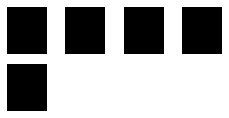

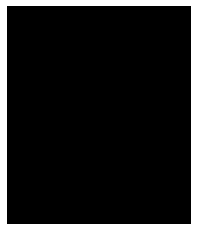

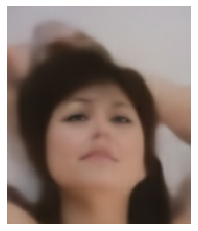

In [ ]:
image_count = 0
for epoch in range(1, epochs):
    clear_output(wait=False)
    print(epoch)
    z = None

    if z == None:
        for test_x in train_ds:
            z = tf.identity(test_x)
            break
    print(test_x.shape)
    print(z.shape)
    generate_and_save_images_from_test_set(model, 0, z)
        
    start_time = time.time()
    for train_x_all in train_ds:
        train_x = train_x_all
        image_count = image_count + train_x.shape[0]
        compute_apply_gradients(model, train_x, optimizer)
        if image_count > images_per_epoch:
            image_count = 0
            break
       
        
    end_time = time.time()
    print("Epoch Time: {}".format(end_time - start_time))
    loss = tf.keras.metrics.Mean()
  
       
    model.save()